In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [158]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta

import numpy as np
import pandas as pd
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import scenario_generator.utils as u
import scenario_generator.curated as curated

In [3]:
save_dir = '/Users/kiran/Documents/baseline_project'
os.makedirs(save_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-06 2033-07-03


In [5]:
baseline = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

In [6]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=180), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=180), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=180), current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

6.0239715576171875 0.6666887721777874 0.8608314524178505


<IPython.core.display.Javascript object>


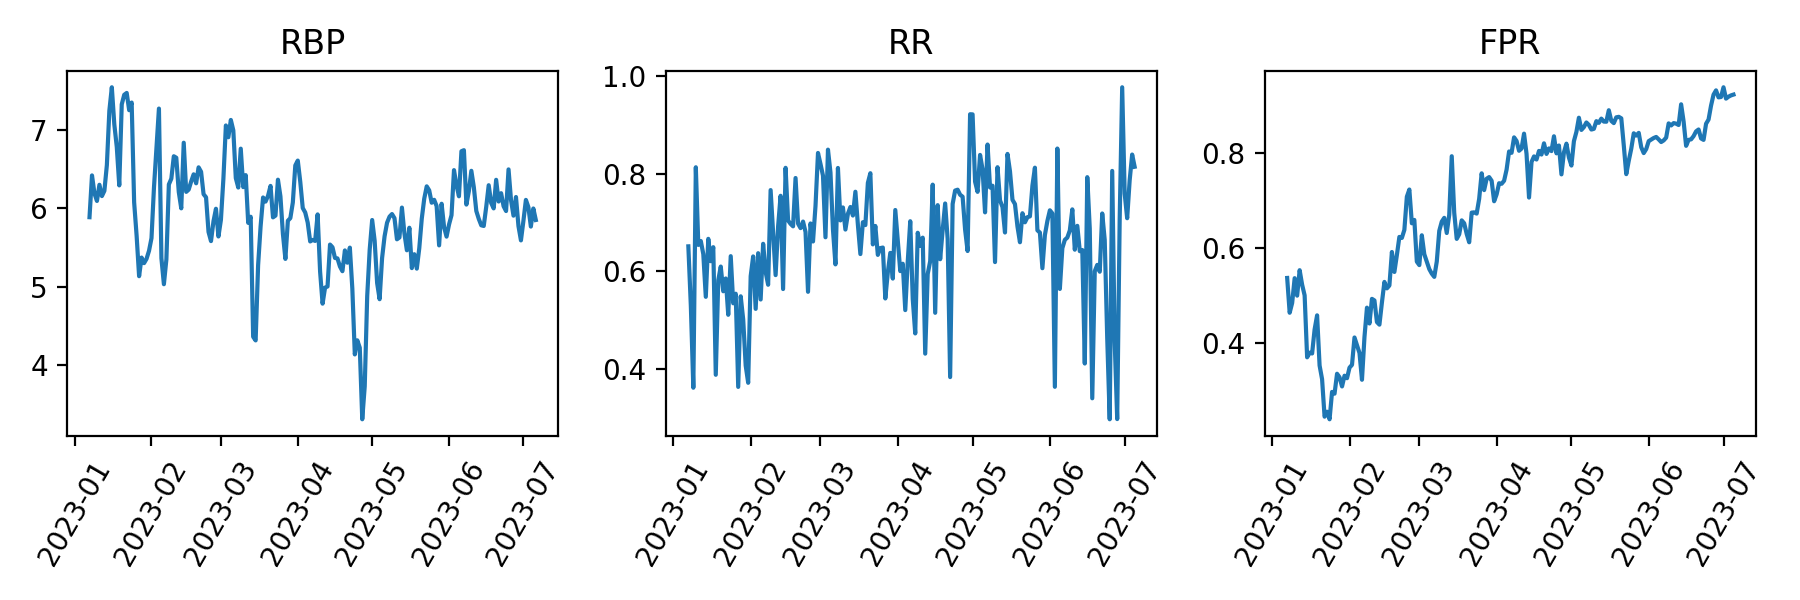

In [7]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()

In [8]:
lock_target = 0.3
sector_duration=540

In [21]:
np.log(2)/(365)*.95

0.0018040817028272549

In [237]:
# create scenarios
g = np.log(2)/(365)
constant_scenarios = {
    '0.25x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.25,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*2,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
    
}
linear_scenarios = {
    '0.25x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.25 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.5 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*2 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*5 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}
exponential_scenarios = {
    '2x': {
        'rbp': smoothed_last_historical_rbp*np.exp(g*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*0.59)*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*1.325)*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

In [238]:
g = np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)
g = 0.59*np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)
g = 1.325*np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)

2.0
1.5052467474110671
2.5053288772482554


<IPython.core.display.Javascript object>


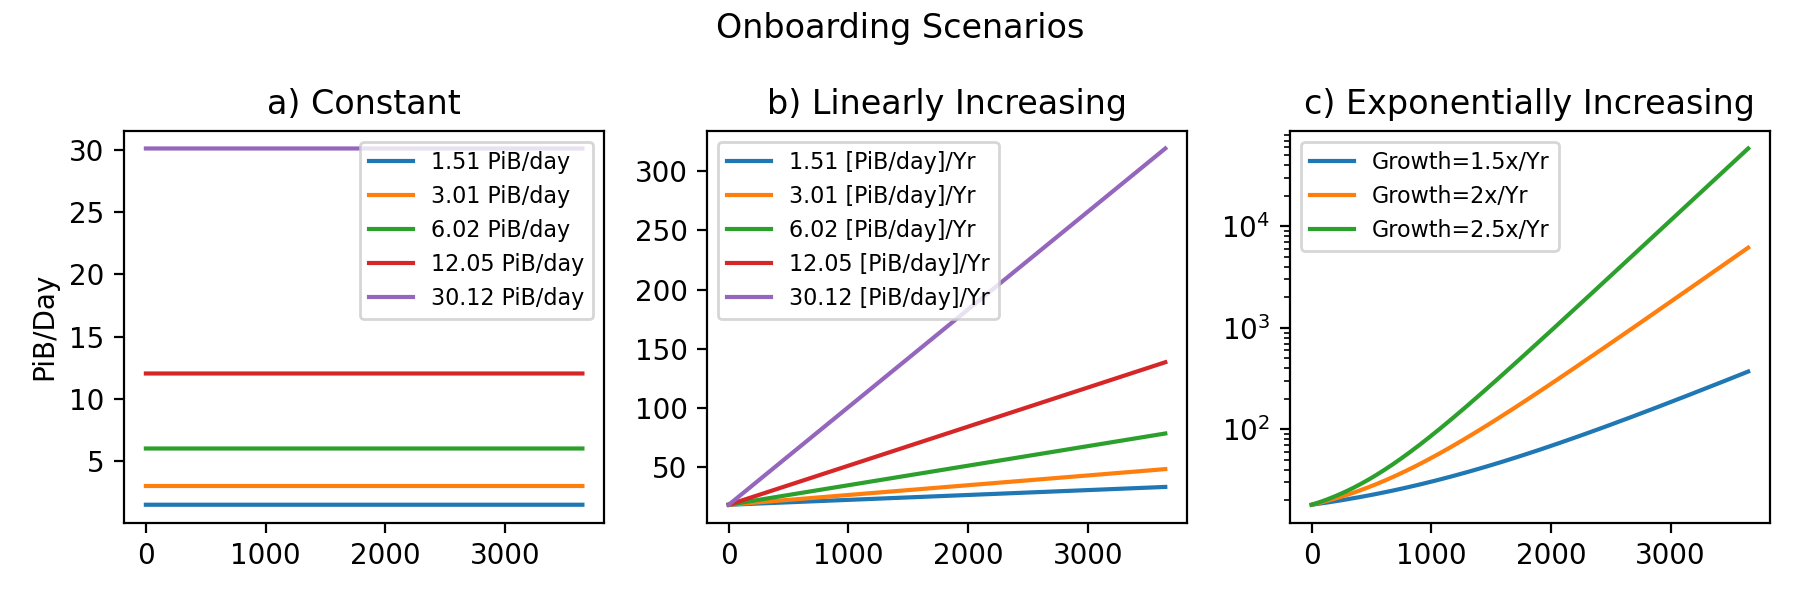

In [293]:
# plot the RBP trajectories for comparison
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
constant_labels = [
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.25x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.5x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['1x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['2x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['5x']['rbp']),)
]
plt.plot(constant_scenarios['0.25x']['rbp'], label=constant_labels[0])
plt.plot(constant_scenarios['0.5x']['rbp'], label=constant_labels[1])
plt.plot(constant_scenarios['1x']['rbp'], label=constant_labels[2])
plt.plot(constant_scenarios['2x']['rbp'], label=constant_labels[3])
plt.plot(constant_scenarios['5x']['rbp'], label=constant_labels[4])
plt.legend(fontsize=8)
# plt.yscale('log')
plt.title('a) Constant')
plt.ylabel('PiB/Day')

plt.subplot(1,3,2)
linear_labels = [
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.25x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.5x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['1x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['2x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['5x']['rbp'])*365,))
]
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
plt.plot(linear_scenarios['0.25x']['rbp'], label=linear_labels[0])
plt.plot(linear_scenarios['0.5x']['rbp'], label=linear_labels[1])
plt.plot(linear_scenarios['1x']['rbp'], label=linear_labels[2])
plt.plot(linear_scenarios['2x']['rbp'], label=linear_labels[3])
plt.plot(linear_scenarios['5x']['rbp'], label=linear_labels[4])
plt.legend(fontsize=8)
# plt.yscale('log')
plt.title('b) Linearly Increasing')

plt.subplot(1,3,3)
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
exp_labels = [
    'Growth=1.5x/Yr',
    'Growth=2x/Yr',
    'Growth=2.5x/Yr'
]
plt.plot(exponential_scenarios['1.5x']['rbp'], label=exp_labels[0])
plt.plot(exponential_scenarios['2x']['rbp'], label=exp_labels[1])
plt.plot(exponential_scenarios['2.5x']['rbp'], label=exp_labels[2])
plt.legend(fontsize=8)
plt.yscale('log')
plt.title('c) Exponentially Increasing')

plt.suptitle('Onboarding Scenarios')

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'rbp_trajectories.png'))

In [294]:
# add ROI to trajectory
def to_np64(x):
    return np.asarray(x, dtype=np.float64)

def add_generated_quantities(results_dict:dict)->dict:
    # add ROI to trajectory df
    days_1y = 365
    
    results_dict['day_pledge_per_QAP'] = C.SECTOR_SIZE * (to_np64(results_dict['day_locked_pledge'])-to_np64(results_dict['day_renewed_pledge']))/(to_np64(results_dict['day_onboarded_power_QAP_PIB'])*C.PIB)
    results_dict['day_rewards_per_sector'] = C.SECTOR_SIZE * to_np64(results_dict['day_network_reward']) / (to_np64(results_dict['network_QAP_EIB'])*C.EIB)
    
    rps = np.convolve(results_dict['day_rewards_per_sector'], np.ones(days_1y), mode='full')
    results_dict['1y_return_per_sector'] = rps[days_1y-1:1-days_1y]
    results_dict['1y_sector_roi'] = results_dict['1y_return_per_sector'] / results_dict['day_pledge_per_QAP'][:1-days_1y]
    
    return results_dict

In [295]:
# run JAX simulation
scenario_vector = [
    ('constant', constant_scenarios),
    ('linear', linear_scenarios),
    ('exponential', exponential_scenarios),
]
scenario_results = {}

for n, scenario_dict in scenario_vector:
    sweep_results = {}
    for scenario_name, trajectories in scenario_dict.items():

        rbp = jnp.array(trajectories['rbp'])
        rr = jnp.array(trajectories['rr'])
        fpr = jnp.array(trajectories['fpr'])

        simulation_results = sim.run_sim(
            rbp,
            rr,
            fpr,
            lock_target,

            start_date,
            current_date,
            forecast_length,
            sector_duration,
            offline_data
        )
        with_roi = add_generated_quantities(simulation_results)

        sweep_results[scenario_name] = with_roi
    scenario_results[n] = sweep_results

total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_16506/2127207903.py:14: RuntimeWarning: divide by zero encountered in divide
  results_dict['1y_sector_roi'] = results_dict['1y_return_per_sector'] / results_dict['day_pledge_per_QAP'][:1-days_1y]


In [296]:
def plot_x(ax, results, key, labels, colors, scale_by=1, start_idx=0):
    sweep_keys = list(results.keys())
    for ii, scenario in enumerate(sweep_keys):
        res = results[scenario]
        ax.plot(t[start_idx:], res[key][start_idx:]/scale_by, label=labels[ii], color=colors[ii])
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

In [319]:
def plot_scenario_results(key='constant', plot_baseline=True, log_scale_power=True, labels=None):
    scenario2results = scenario_results[key]
    keys = list(scenario2results.keys())
    if labels is None:
        labels = list(scenario2results.keys())
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,10))

    c_vec = [c(0.6) for c in colors]

    axx = ax[0,0]
    plot_x(axx, scenario2results, 'rb_total_power_eib', labels, c_vec)
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    axx.legend(fontsize=8)
    if log_scale_power:
        axx.set_yscale('log')
        axx.set_ylim(0)

    axx = ax[0,1]
    plot_x(axx, scenario2results, 'qa_total_power_eib', labels, c_vec)
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    axx.set_ylim(0)
    if plot_baseline:
        axx.plot(t, baseline, linestyle=':', label='Baseline')
        if not log_scale_power:
            if key == 'constant':
                axx.set_ylim(10,400)
            elif key == 'linear':
                axx.set_ylim(10,4000)
    if log_scale_power:
        axx.set_yscale('log')
        axx.set_ylim(0)

    axx = ax[1,0]
    plot_x(axx, scenario2results, 'day_network_reward', labels, c_vec)
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    axx.set_ylim(0)

    axx = ax[1,1]
    plot_x(axx, scenario2results, 'network_locked', labels, c_vec, scale_by=1e6)
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.axhline(0, linestyle=':', color='k')
    axx.set_ylim(0)

    axx = ax[2,0]
    plot_x(axx, scenario2results, 'circ_supply', labels, c_vec, scale_by=1e6)
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    axx.set_ylim(0)

    axx = ax[2,1]
    for ii, sc in enumerate(keys):
        res = scenario2results[sc]
        axx.plot(t, res['network_locked']/res['circ_supply'], label=labels[ii], color=c_vec[ii])
    for tick in axx.get_xticklabels():
        tick.set_rotation(60)
    axx.set_title('L/CS')
    axx.set_ylim(0)
    
    axx = ax[3,0]
    plot_x(axx, scenario2results, 'day_pledge_per_QAP', labels, c_vec, start_idx=1)
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    axx.set_ylim(0)
    
    axx = ax[3,1]
    for ii, sc in enumerate(keys):
        res = scenario2results[sc]
        axx.plot(t[:-364], res['1y_sector_roi']*100, label=labels[ii], color=c_vec[ii])
    for tick in axx.get_xticklabels():
        tick.set_rotation(60)
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    axx.set_ylim(0)
    
    plt.suptitle('%s Onboarding Scenarios' % (key.upper(),))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, '%s_locked_trajectories.png' % (key,)))

<IPython.core.display.Javascript object>


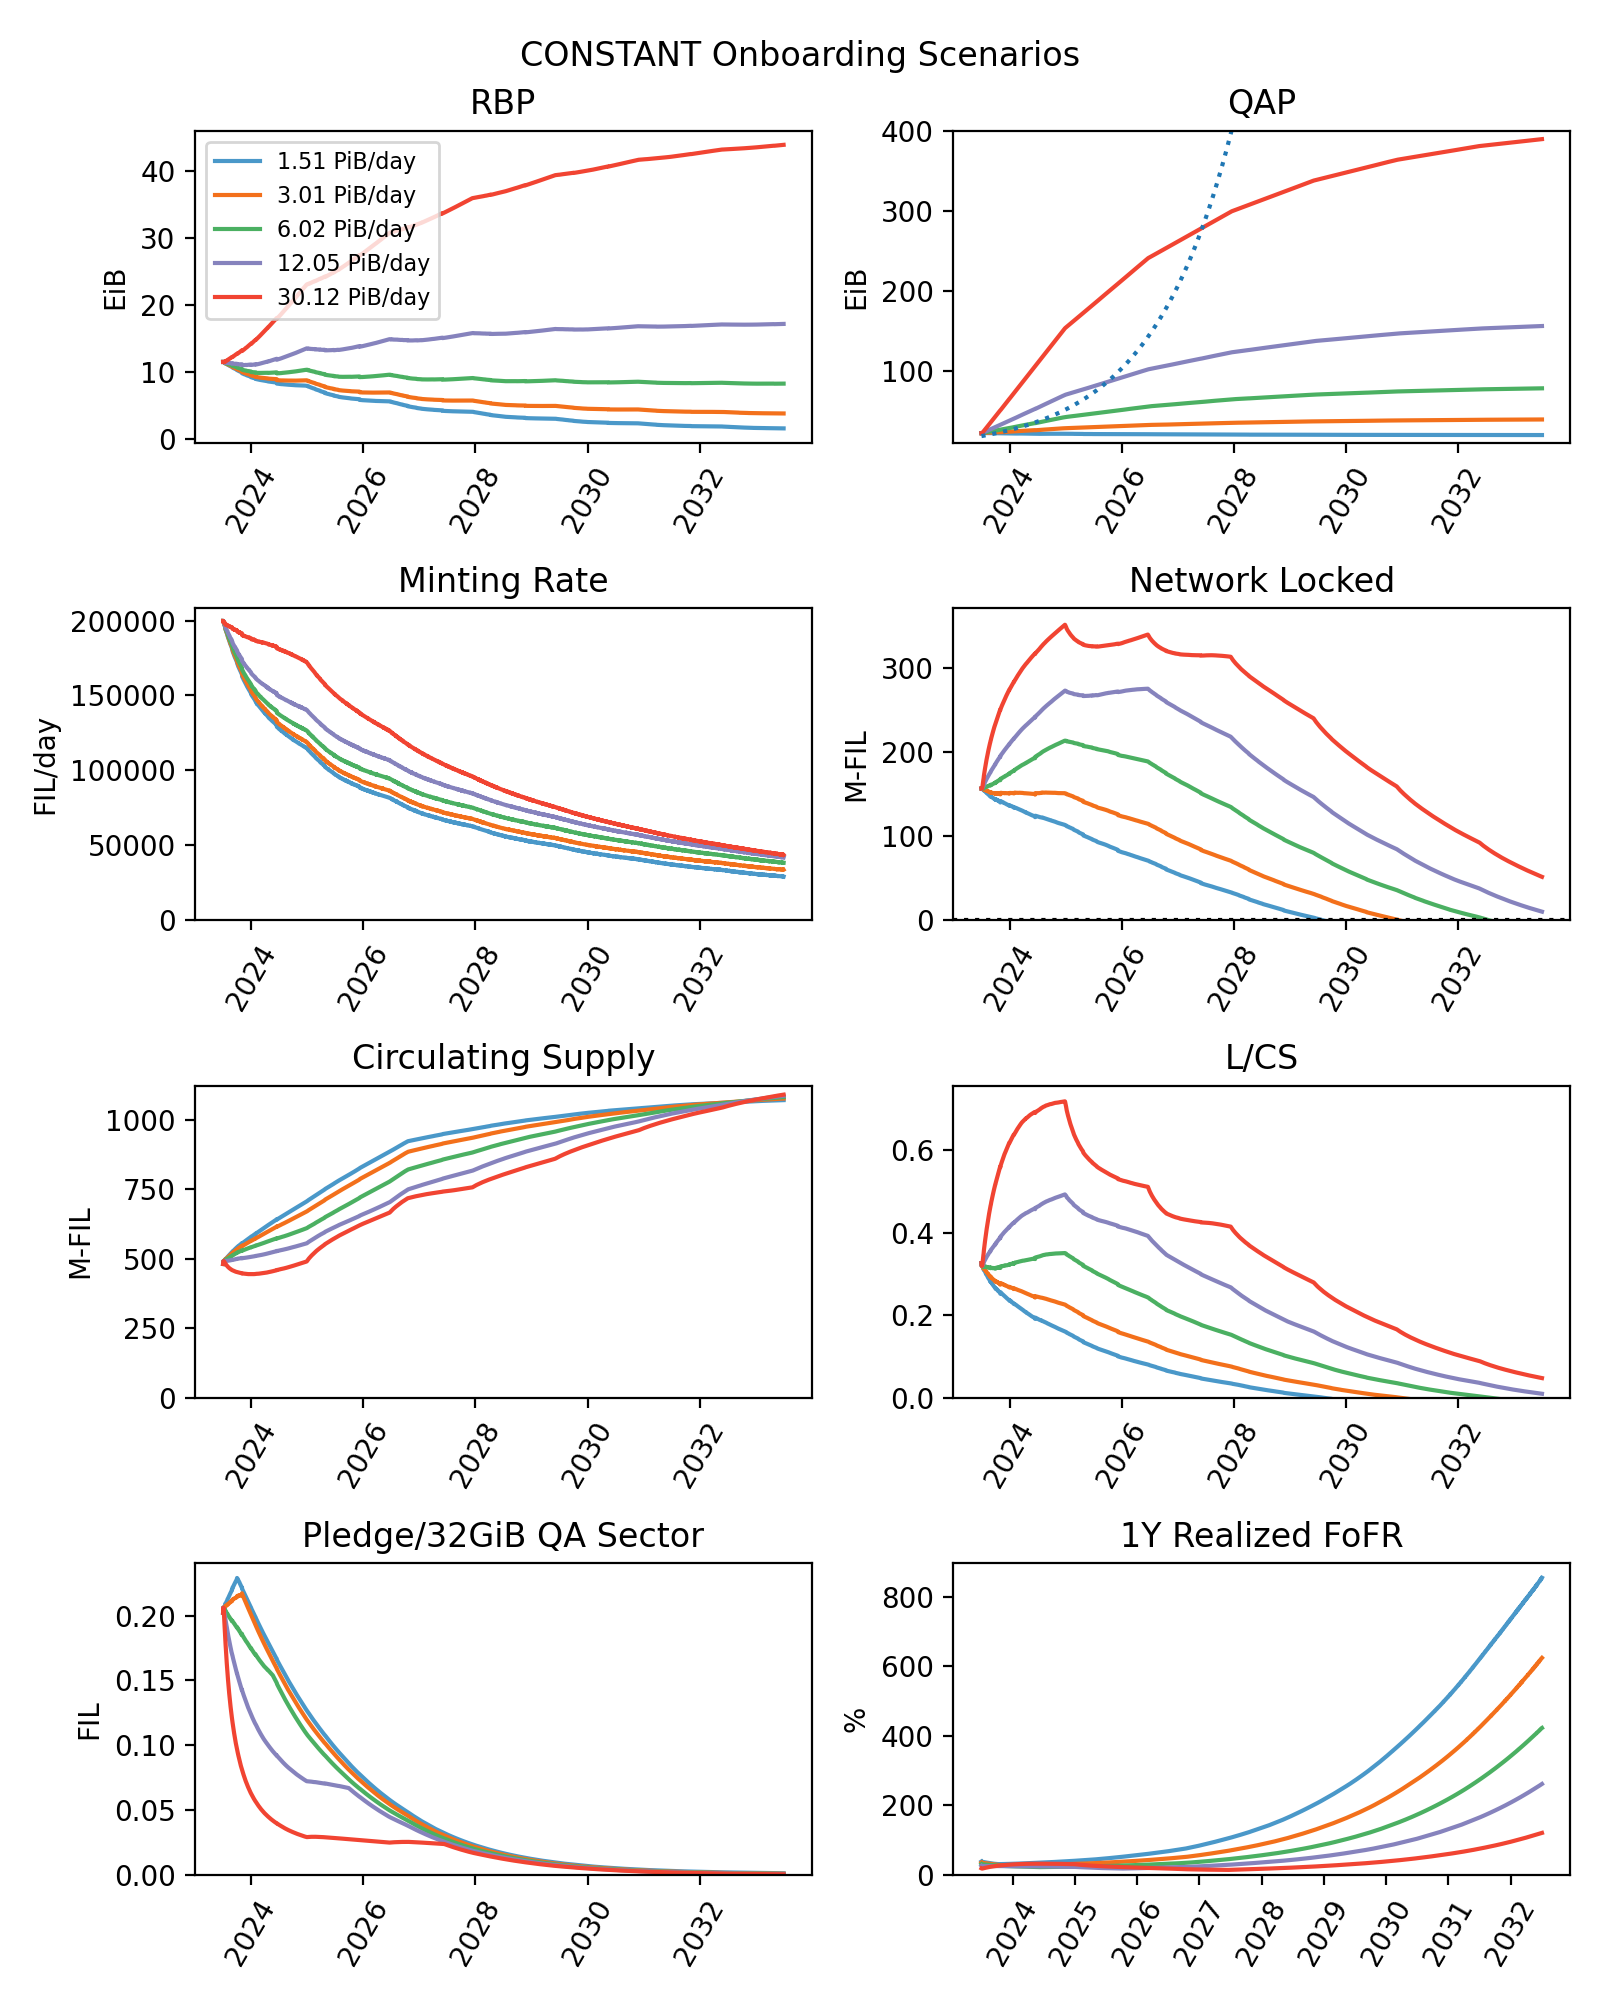

In [320]:
plot_scenario_results(key='constant', plot_baseline=True, log_scale_power=False, labels=constant_labels)

<IPython.core.display.Javascript object>


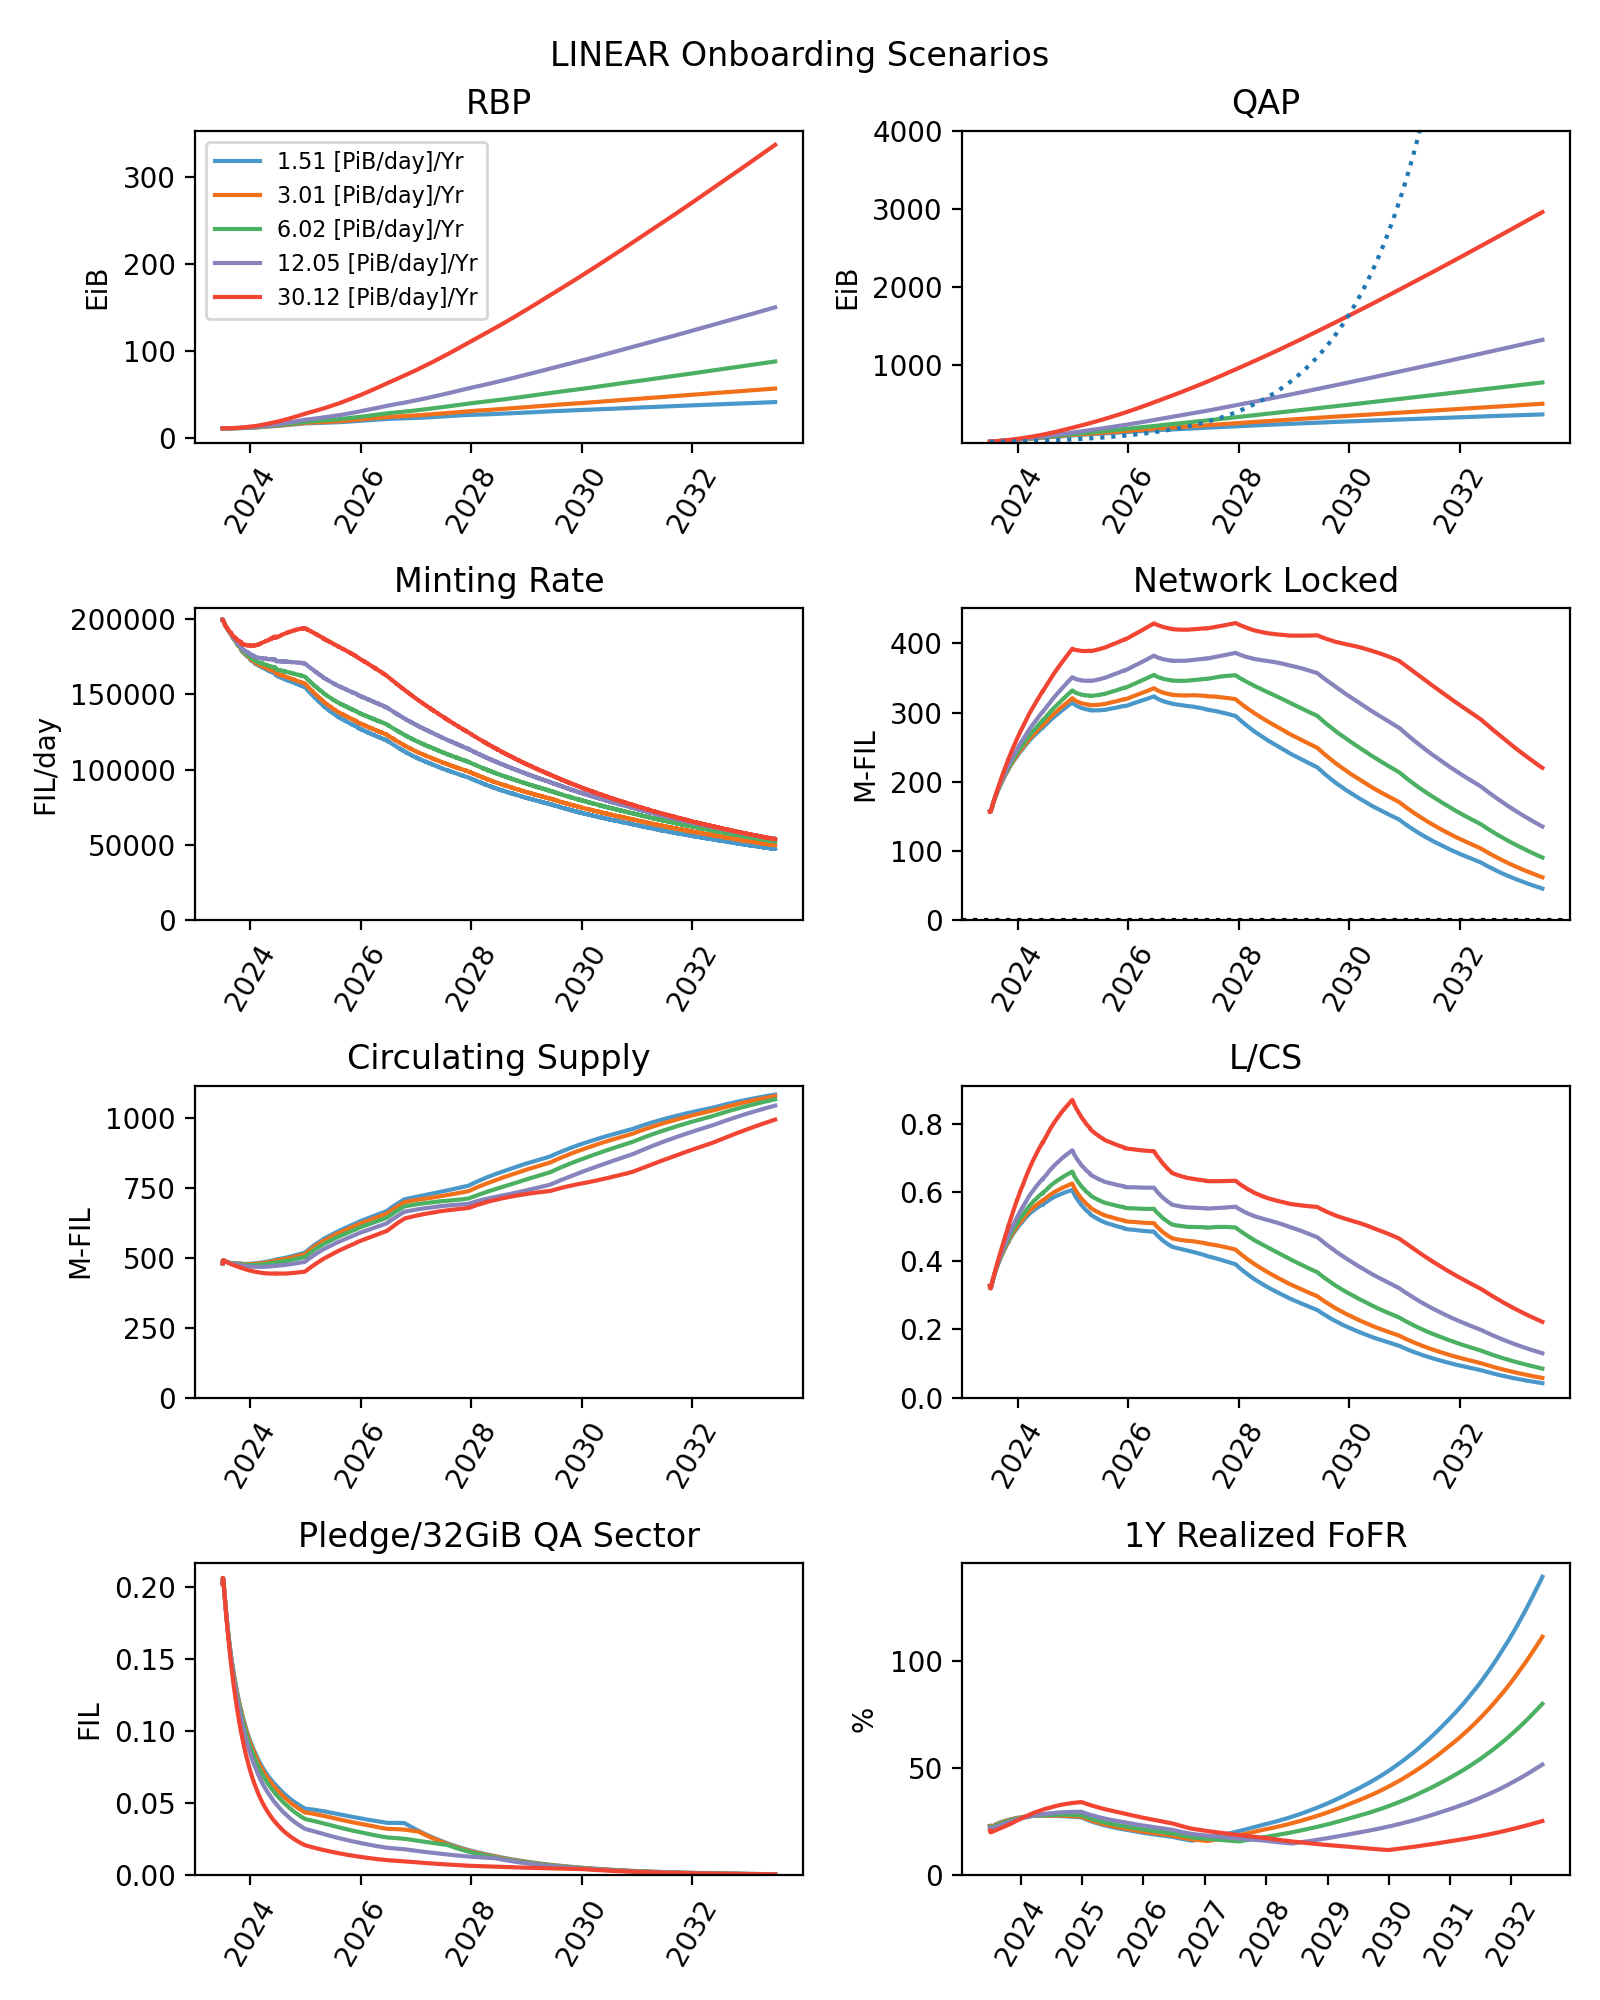

In [321]:
plot_scenario_results(key='linear', plot_baseline=True, log_scale_power=False, labels=linear_labels)

<IPython.core.display.Javascript object>


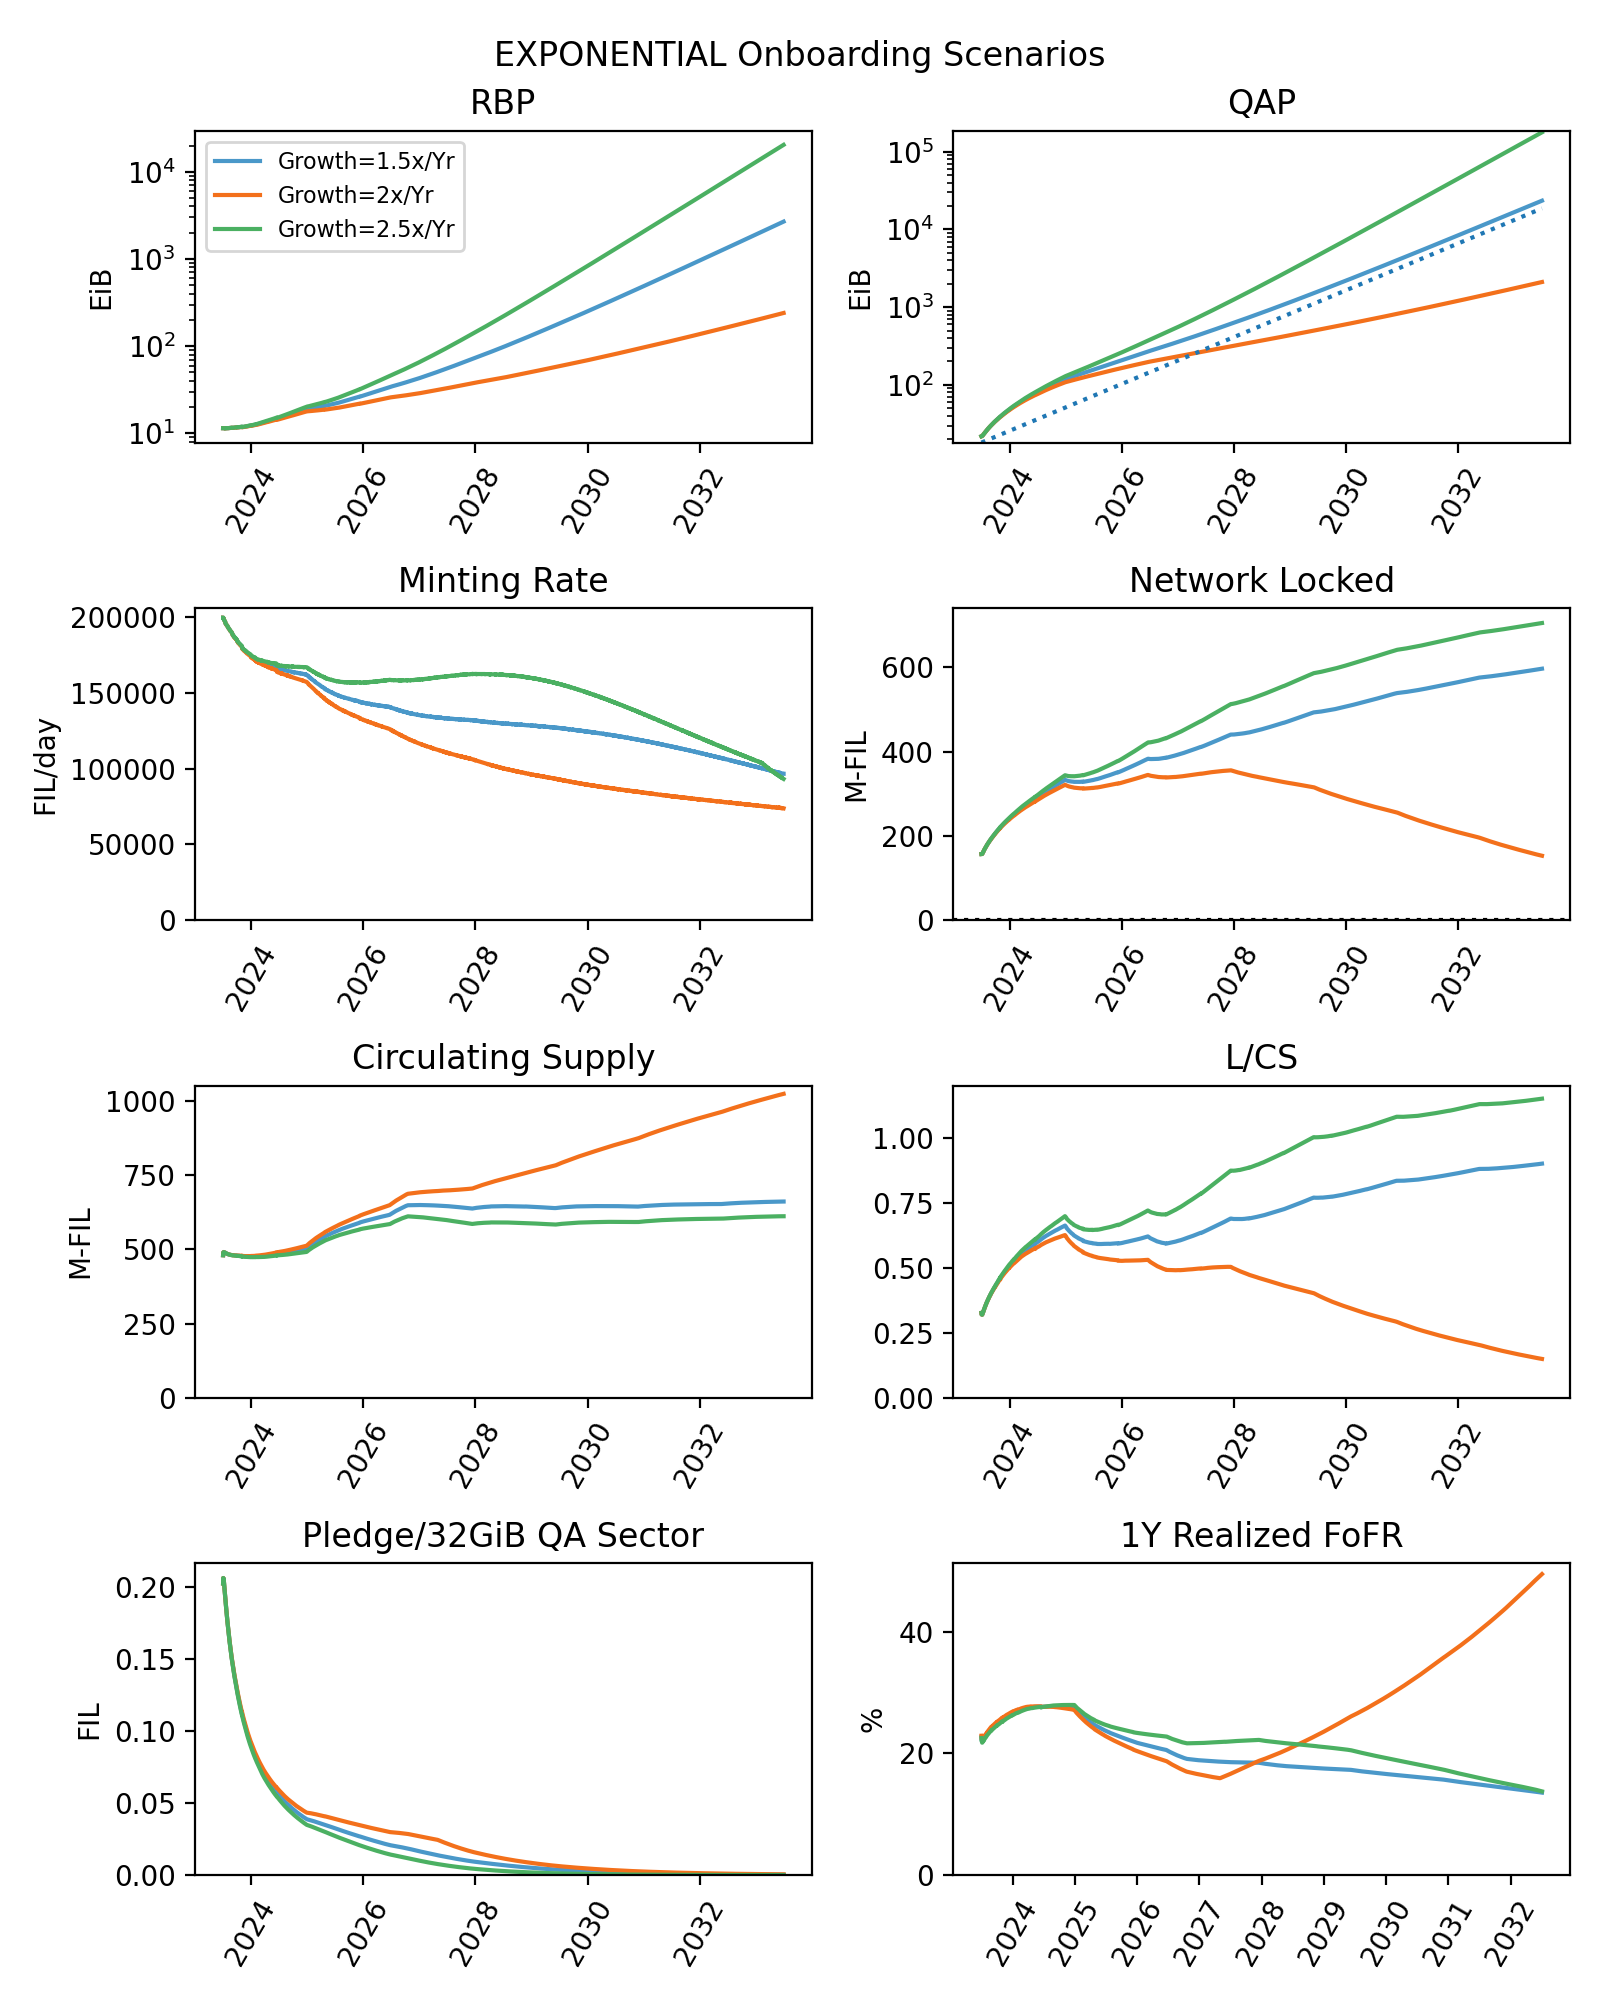

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_16506/1947548459.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axx.set_ylim(0)
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_16506/1947548459.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axx.set_ylim(0)


In [322]:
plot_scenario_results(key='exponential', log_scale_power=True, labels=exp_labels)

In [178]:
CROSS_CHECK_WITH_NUMPY_MECHAFIL = True

def add_generated_quantities_np(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    duration=365
    df['day_pledge_per_QAP'] = C.SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = C.SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

if CROSS_CHECK_WITH_NUMPY_MECHAFIL:
    # cross-check w/ numpy for the status-quo simulation
    np_df = np_sim.run_simple_sim(
        start_date,
        current_date,
        forecast_length,
        constant_scenarios['1x']['rr'],
        constant_scenarios['1x']['rbp'],
        constant_scenarios['1x']['fpr'],
        sector_duration,
        token
    )
    np_df = add_generated_quantities_np(np_df)

<IPython.core.display.Javascript object>


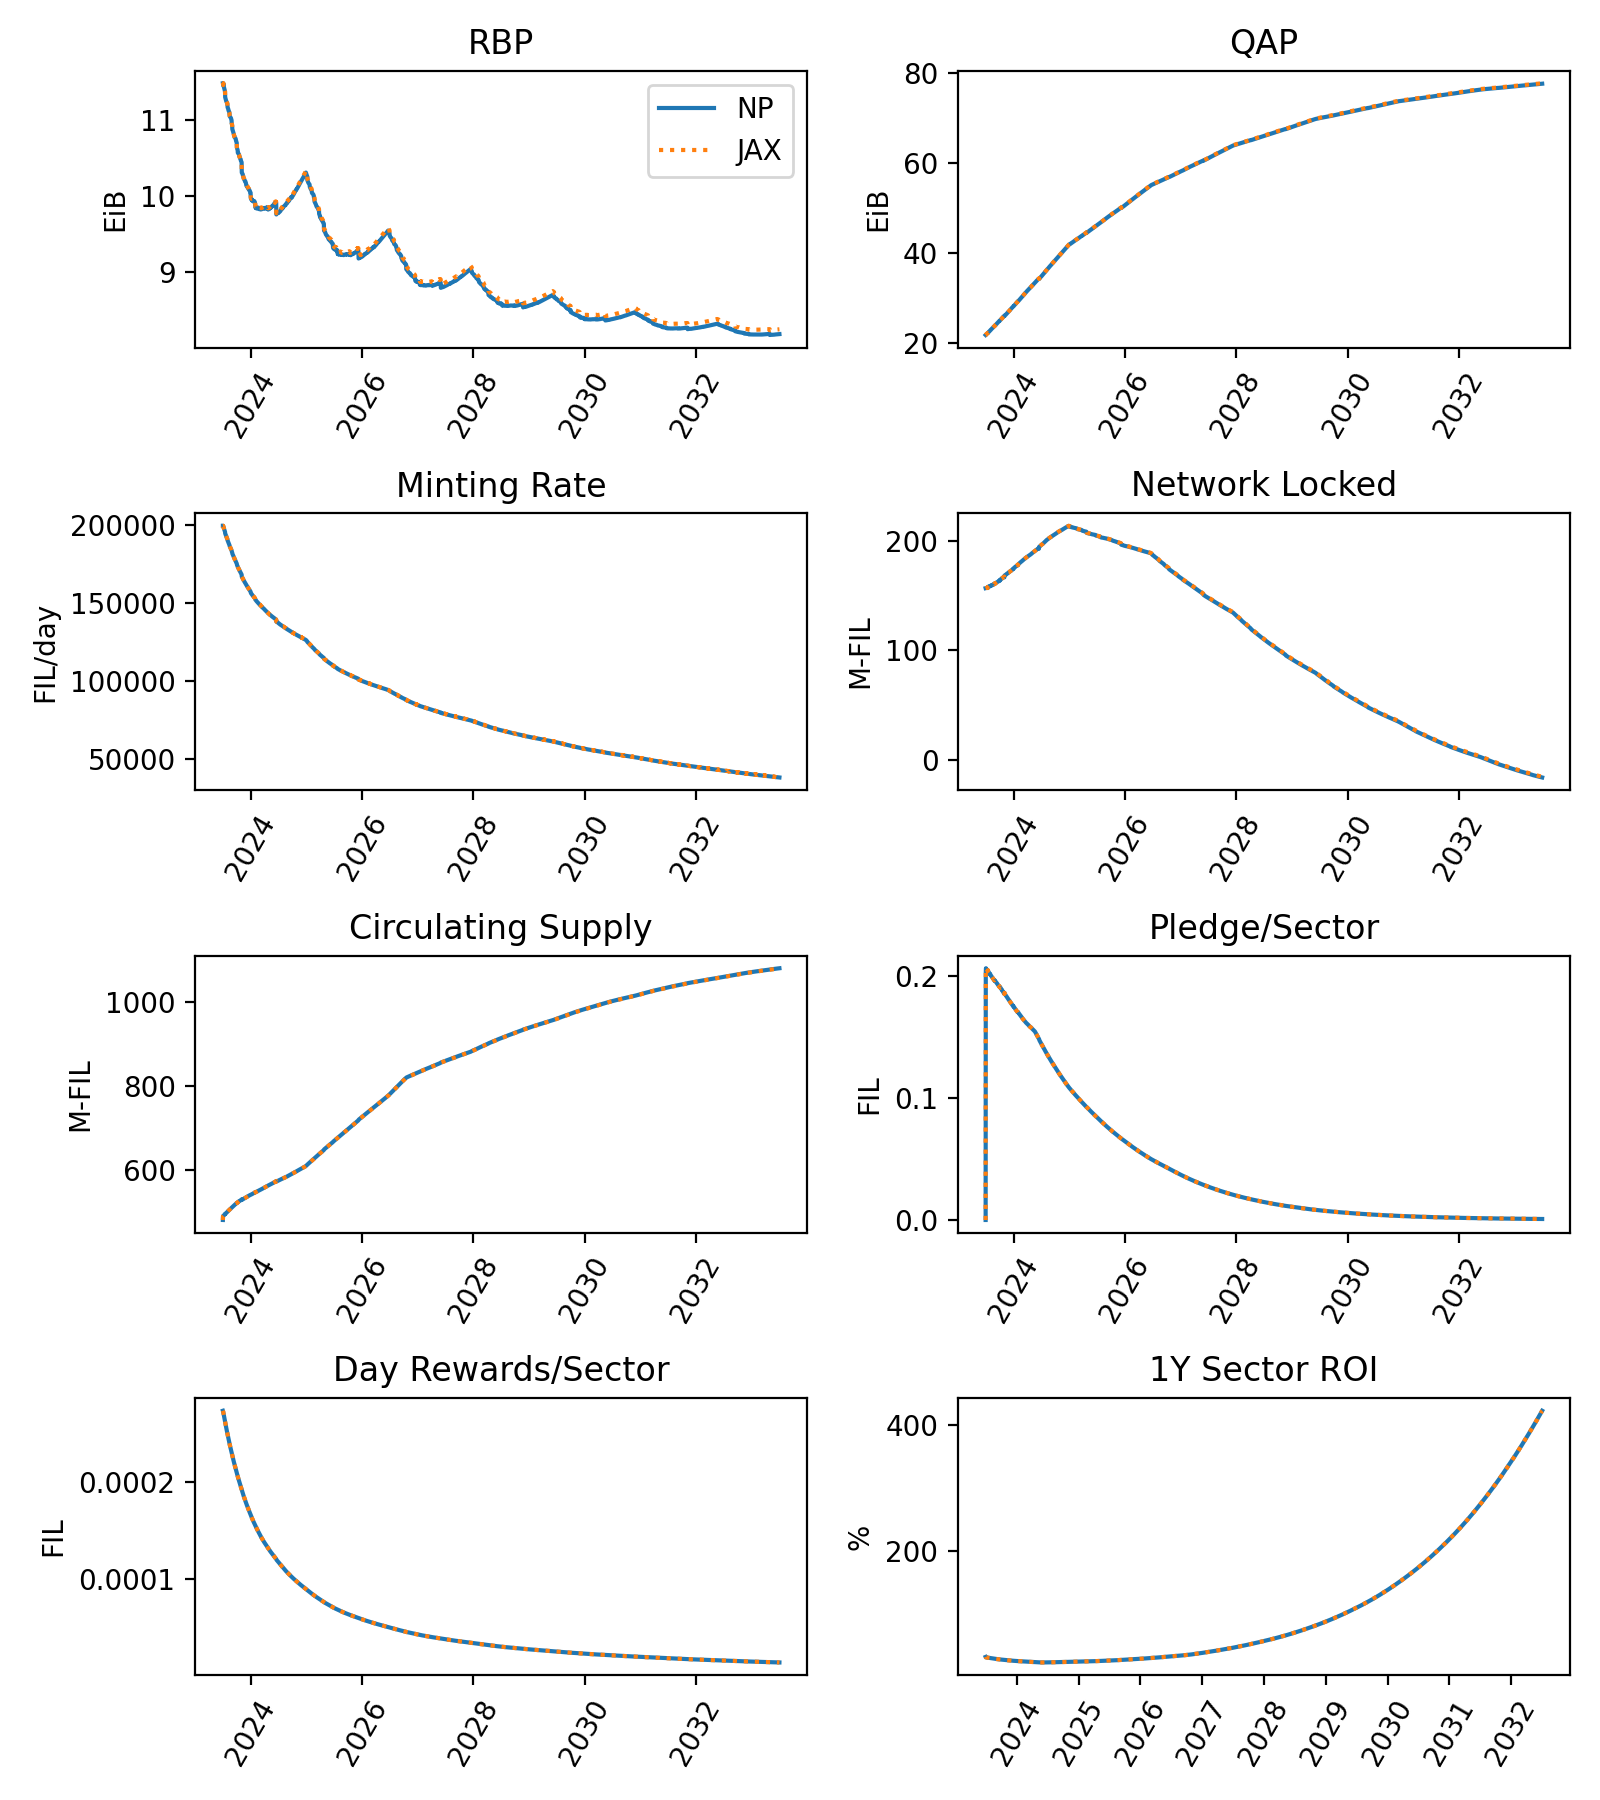

In [219]:
if CROSS_CHECK_WITH_NUMPY_MECHAFIL:
    res = scenario_results['constant']['1x']
    
    plt.figure(figsize=(8,9))

    plt.subplot(4,2,1)
    plt.plot(np_df['date'], np_df['network_RBP']/C.EXBI, label='NP')
    plt.plot(t, res['rb_total_power_eib'], label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.ylabel('EiB')
    plt.title('RBP')
    plt.legend()

    plt.subplot(4,2,2)
    plt.plot(np_df['date'], np_df['network_QAP']/C.EXBI, label='NP')
    plt.plot(t, res['qa_total_power_eib'], label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.ylabel('EiB')
    plt.title('QAP')

    plt.subplot(4,2,3)
    plt.plot(np_df['date'], np_df['day_network_reward'], label='NP')
    plt.plot(t, res['day_network_reward'], label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('Minting Rate')
    plt.ylabel('FIL/day')

    plt.subplot(4,2,4)
    plt.plot(np_df['date'], np_df['network_locked']/1e6, label='NP')
    plt.plot(t, res['network_locked']/1e6, label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('Network Locked')
    plt.ylabel('M-FIL')

    plt.subplot(4,2,5)
    plt.plot(np_df['date'], np_df['circ_supply']/1e6, label='NP')
    plt.plot(t, res['circ_supply']/1e6, label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('Circulating Supply')
    plt.ylabel('M-FIL')

    plt.subplot(4,2,6)
    plt.plot(np_df['date'], np_df['day_pledge_per_QAP'], label='NP')
    plt.plot(t, res['day_pledge_per_QAP'], label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('Pledge/Sector')
    plt.ylabel('FIL')
    
    plt.subplot(4,2,7)
    plt.plot(np_df['date'], np_df['day_rewards_per_sector'], label='NP')
    plt.plot(t, res['day_rewards_per_sector'], label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('Day Rewards/Sector')
    plt.ylabel('FIL')
    
    plt.subplot(4,2,8)
#     plt.plot(np_df['date'], np_df['1y_return_per_sector'], label='NP')
#     plt.plot(t[:-364], res['1y_return_per_sector'], label='JAX', linestyle=':')
    plt.plot(np_df['date'], np_df['1y_sector_roi']*100, label='NP')
    plt.plot(t[:-364], res['1y_sector_roi']*100, label='JAX', linestyle=':')
    plt.xticks(rotation=60)
    plt.title('1Y Sector ROI')
    plt.ylabel('%')

    plt.tight_layout()